In [30]:
import numpy as np
from functools import partial
import sobol_seq
import re
import matplotlib.pyplot as plt

**Problem 1 Pak Kun**

In [31]:
def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])

dim = 2
boundaries = np.array([(-10,10) for _ in range (dim)])
mutation_factor=0.5
crossover_rate=0.5
num_l=20
theta=-1+1e-3
tau_d=0.4
print_gen=True
Hm = 50

m_cluster = 100
gamma = -0.2
epsilon = 10**(-3)
delta = 0.01
k_cluster = 10
m = 100
k_max = 200

# Objective Function

In [32]:
def root_objective_function(x:np.ndarray):
    res = 0
    F_array = objective_function(x)
    for f in F_array:
        res += np.abs(f)
    return -1/(1+res)

In [34]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim: int,
                    npoint:int,
                    low=-10,
                    high=10,
                    sobol = True):
    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')
    if type(low) == int:
        boundaries = [(low,high) for _ in range (dim)]
    elif type(low) == list or type(low) == np.ndarray:
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i],high[i]) for i in range (len(low))]

    if sobol == True:
        # Generate Sobol sequence points
        sobol_points = sobol_seq.i4_sobol_generate(dim, npoint)
        # Scale the Sobol points to fit within the specified boundaries
        scaled_points = []
        for i in range(dim):
            a, b = boundaries[i]
            scaled_dim = a + sobol_points[:, i] * (b - a)
            scaled_points.append(scaled_dim)
        # Transpose the scaled points to get points per dimension
        scaled_points = np.array(list(map(list, zip(*scaled_points))))
    
    else:
        scaled_points = np.zeros((npoint, dim))
        for i in range(dim):
            min_val, max_val = boundaries[i]
            scaled_points[:, i] = np.random.uniform(min_val, max_val, npoint)

    return scaled_points

# def initialize_population(pop_size, dimensions, bounds):
#     population = np.random.rand(pop_size, dimensions)
#     lower_bounds, upper_bounds = np.asarray(bounds).T
#     diff = np.fabs(lower_bounds - upper_bounds)
#     return lower_bounds + population * diff

In [35]:
# Mutation function for DE
def mutate(population, F):
    # Vectorized mutation operation
    indices = np.arange(population.shape[0])
    np.random.shuffle(indices)
    r1, r2, r3 = population[indices[:3]]
    mutant = r1 + F * (r2 - r3)
    return mutant

def crossover(target, mutant, CR):
    cross_points = np.random.random(target.shape) < CR
    # Ensure at least one true crossover point
    if not np.any(cross_points):
        cross_points[np.random.randint(0, target.shape[0])] = True
    trial = np.where(cross_points, mutant, target)
    return trial

def mutation_penalty(x_i, subpop_i, boundaries, scaling_factor):
    """GENERATE: three distinct individuals xr1, xr1, xr1 from the current population randomly"""
    subpop_i_copy = subpop_i.copy()
    pop_ids = np.arange(subpop_i_copy.shape[0])
    indices_to_delete = np.where(np.all(subpop_i_copy == x_i, axis=1))[0] # Ensure that x_i is excluded from the selected subpopulation
    subpop_ids_no_i = np.delete(pop_ids, indices_to_delete, axis=0)
    subpop_i_copy = subpop_i_copy[subpop_ids_no_i]

    """MUTATION: Form the donor/mutation vector"""
    dv_i = mutate(subpop_i_copy,scaling_factor)

    """Set penalty for every donor vector that violates the boundaries"""
    for j in range (len(dv_i)):
        if dv_i[j] < boundaries[j,0]:
            dv_i[j] = (x_i[j]+boundaries[j,0])/2
        elif dv_i[j] > boundaries[j,1]:
            dv_i[j] = (x_i[j]+boundaries[j,1])/2
    return dv_i


In [36]:
"""FInd the closest points in a set to an initial point"""
def closest_solution(initial_point,set_of_points):
    diff = set_of_points-initial_point
    distances = np.linalg.norm(diff,axis=1)
    id_min_dist = np.argmin(distances)
    return id_min_dist,set_of_points[id_min_dist]

# # test the function
# alpha = np.array([1, 1])
# B = np.array([[5, 2],
#               [3, 4],
#               [5, 5]])
# closest_solution(alpha,B)

In [37]:
k=0
iter_points = {}
iter_points[k] = generate_points(dim,m_cluster,boundaries[:,0],boundaries[:,1])
fitness = np.asarray([root_objective_function(ind) for ind in iter_points[0]])
best_idx = np.argmin(fitness)
x_prime = iter_points[0][best_idx]

radius = (boundaries[:,1]-boundaries[:,0])/2
id_rad = np.argmin(radius)
radii = radius[id_rad]

cluster_center,cluster_radius = np.array([x_prime]),np.array([radii])
# cluster_center[0],cluster_radius[0] = x_prime,radius
print(cluster_center,cluster_radius)

[[-1.25  1.25]] [10.]


In [38]:
"""FUNCTION CLUSTER"""
def function_cluster(y):
    # min_dist_cluster = 10**100
    # for ci,cc in cluster_center.items():
    #     dist = np.linalg.norm(cc-y)
    #     if dist<=min_dist_cluster:
    #         xc = cc
    #         cluster_id = ci
    #         min_dist_cluster = dist
    global cluster_center
    global cluster_radius
    dist_list = np.linalg.norm(cluster_center-y,axis=1)
    min_dist_id = np.argmin(dist_list)
    min_dist = dist_list[min_dist_id]
    xc = cluster_center[min_dist_id]
    xt = (xc + y)/2
    # print(xt,xc,y)
    Fxt = root_objective_function(xt)
    Fxc = root_objective_function(xc)
    Fy = root_objective_function(y)
    # print(Fxt,Fxc,Fy)
    if (Fxt > Fy) & (Fxt > Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
    elif (Fxt < Fy) & (Fxt < Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
        function_cluster(xt)
    elif Fy < Fxc:
        cluster_center[min_dist_id] = y
    
    cluster_radius[min_dist_id] =  np.linalg.norm(y-xt)
    # # update radii if the existing corresponding cluster radii is larger than tha candidate
    # if cluster_radius[min_dist_id] > np.linalg.norm(y-xt):
    #     cluster_radius[min_dist_id] =  np.linalg.norm(y-xt)
    
    # return cluster_center,cluster_radius


In [39]:
import importlib
import re

import sys
module_path = r"D:\OneDrive - Institut Teknologi Bandung\[AKADEMIK]\Semester 7-8\TA\Thesis\Thesis - Python\Differential Evolution"
sys.path.append(module_path)
import deal as dl
importlib.reload(dl)

sys.path.remove(module_path)


In [40]:
seed = np.random.randint(0,100)
print(f"seed={seed}")

while k<k_cluster:
    potential_cluster_center = []
    F = root_objective_function(iter_points[k].T)
    for i in range (m_cluster):
        # If F(x_i)<gamma and x_i is not the center of existing cluster, x_i may have a possibility to become a cluster center
        if len(iter_points[k].T) == 1:
            fungam = F[0][i]
        else:
            fungam = F[i]
        exist_in_cluster_center = any(np.linalg.norm(iter_points[k][i] - ctr) < epsilon for ctr in cluster_center)
        if (fungam < gamma) & (exist_in_cluster_center==False):
            potential_cluster_center.append(iter_points[k][i])
        # print(f'potential_cluster_center:{potential_cluster_center}')
    # Apply function cluster
    for i in range (len(potential_cluster_center)):
        function_cluster(potential_cluster_center[i])
    fitness_k = np.asarray([root_objective_function(ind) for ind in iter_points[k]])
    i_g = np.argmin(fitness)
    x_i_g = iter_points[k][i_g]
    iter_points[k+1] = np.copy(iter_points[k])
    iter_points[k+1] = dl.reproduction(population=iter_points[k+1],
                                       objective_func=root_objective_function,
                                       boundaries=boundaries,
                                       mutation_factor=0.5,
                                       crossover_rate=0.5,
                                       seed=seed)

    k+=1
print(f"len(cluster_center)={len(cluster_center)}\ncluster_center={cluster_center}")

seed=93


len(cluster_center)=37
cluster_center=[[-0.9375      1.03759766]
 [-0.25390625  0.68359375]
 [ 0.69389343  0.67382812]
 [-4.765625   -0.10742188]
 [-0.03417969  9.296875  ]
 [-2.67944336 -0.04150391]
 [-2.36328125 -0.0390625 ]
 [-2.50976562  0.01953125]
 [-3.30810547  0.07324219]
 [-2.77587891 -0.13183594]
 [ 0.1171875   5.0390625 ]
 [-0.15625     5.1953125 ]
 [-1.3671875  -0.01953125]
 [ 1.12731934  0.41259766]
 [-0.06835938  9.6875    ]
 [ 0.1171875   6.42578125]
 [ 0.1171875   7.34375   ]
 [-1.92581177  0.11383057]
 [-1.47460938  0.44433594]
 [-0.18676758  1.640625  ]
 [-0.03417969  1.74316406]
 [ 0.32653809  0.55480957]
 [ 0.1171875   5.5078125 ]
 [-0.44372559  0.74783325]
 [-0.26672363  1.44897461]
 [-3.64746094  0.45898438]
 [-0.70129395  1.30767822]
 [-0.9375      1.13769531]
 [-1.26953125  0.546875  ]
 [ 0.60760498  0.9375    ]
 [ 0.62187195  0.76583862]
 [ 0.57861328  0.7699585 ]
 [-0.60180664  1.33605957]
 [ 0.45776367  0.48461914]
 [ 0.12207031  1.2210083 ]
 [-0.06835938  1.

Cluster Visualization

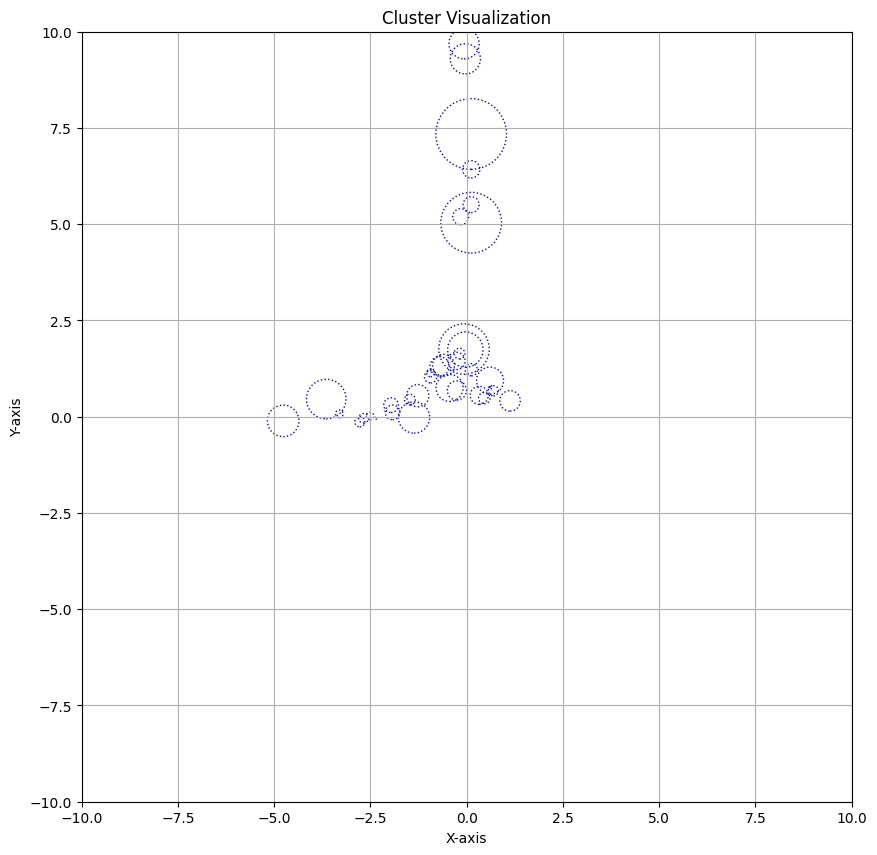

In [41]:
if dim != 2:
    print(f"Dimension {dim} can be visualized using cluster_visualization2D.")
"""Visualization"""
fig, ax = plt.subplots(figsize=(10,10))
for center,radius in zip(cluster_center,cluster_radius):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()

In [42]:
answ = np.array([[-6.437160, 0.155348],
                 [-0.932122, 1.067870],
                 [-0.155283, 6.439840],
                 [0.163333, 6.122430],
                 [0.667121, 0.690103],
                 [-6.117110, -0.163476]])

possible_cluster_id = []
for i in range (len(cluster_center)):
    for j in range (len(answ)):
        ddist = np.linalg.norm(cluster_center[i]-answ[j])
        if ddist <= cluster_radius[i]:
            possible_cluster_id.append([i,j])
            print(f'cluster_center[{i}] x answ[{j}]')


cluster_center[0] x answ[1]
cluster_center[2] x answ[4]
cluster_center[27] x answ[1]
cluster_center[29] x answ[4]


# SDDE Evaluation

In [43]:
archive = []
for i in range (len(cluster_center)):
    subbound = np.array([cluster_center[i]-cluster_radius[i],cluster_center[i]+cluster_radius[i]])
    root, root_score = dl.differensial_evolution(objective_func=root_objective_function,
                                                 population_size=m,
                                                 boundaries=subbound, 
                                                 gen_max=k_max, 
                                                 mutation_factor=mutation_factor, 
                                                 crossover_rate=crossover_rate,
                                                 seed=seed,
                                                 print_gen = False,
                                                 history = False)
    archive.append(root)
    print(f'\n====== Cluster {i} ======\n')
    print(f'Roots = {archive}')
archive


====== Cluster 0 ======

Roots = [array([0.6671212, 0.6901032])]

====== Cluster 1 ======

Roots = [array([0.6671212, 0.6901032]), array([0.43266205, 0.93452545])]

====== Cluster 2 ======

Roots = [array([0.6671212, 0.6901032]), array([0.43266205, 0.93452545]), array([0.56046678, 0.80538345])]

====== Cluster 3 ======

Roots = [array([0.6671212, 0.6901032]), array([0.43266205, 0.93452545]), array([0.56046678, 0.80538345]), array([-5.17511222, -0.14613421])]

====== Cluster 4 ======

Roots = [array([0.6671212, 0.6901032]), array([0.43266205, 0.93452545]), array([0.56046678, 0.80538345]), array([-5.17511222, -0.14613421]), array([0.6671212, 0.6901032])]

====== Cluster 5 ======

Roots = [array([0.6671212, 0.6901032]), array([0.43266205, 0.93452545]), array([0.56046678, 0.80538345]), array([-5.17511222, -0.14613421]), array([0.6671212, 0.6901032]), array([-1.63516391,  0.08261975])]

====== Cluster 6 ======

Roots = [array([0.6671212, 0.6901032]), array([0.43266205, 0.93452545]), array(

[array([0.6671212, 0.6901032]),
 array([0.43266205, 0.93452545]),
 array([0.56046678, 0.80538345]),
 array([-5.17511222, -0.14613421]),
 array([0.6671212, 0.6901032]),
 array([-1.63516391,  0.08261975]),
 array([-1.56023659, -0.0103014 ]),
 array([-1.65077086,  0.11779596]),
 array([-3.18291287e+00, -1.63148008e-04]),
 array([-1.57109529e+00,  2.99184897e-04]),
 array([0.47712496, 0.90579195]),
 array([0.6671212, 0.6901032]),
 array([-1.57642164,  0.38700504]),
 array([0.66867259, 0.68680573]),
 array([0.6671212, 0.6901032]),
 array([0.6671212, 0.6901032]),
 array([0.16333346, 6.12243408]),
 array([-1.62722269,  0.30454254]),
 array([0.30440693, 0.56970738]),
 array([0.6671212, 0.6901032]),
 array([0.6671212, 0.6901032]),
 array([0.32092284, 0.57132716]),
 array([0.6671212, 0.6901032]),
 array([-0.79488692,  1.09899459]),
 array([0.6671212, 0.6901032]),
 array([-1.02724596,  0.97275394]),
 array([0.6671212, 0.6901032]),
 array([0.6671212, 0.6901032]),
 array([-1.16339905,  0.83647781])

In [44]:
if dim == 1:
    list_criteria = [element for sublist in archive for element in sublist] #convert from 2D array into 1D array
else:
    list_criteria = archive
eligible_roots = np.array([x for x in list_criteria if (root_objective_function(x))<-1+epsilon])
eligible_roots

array([[0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.16333346, 6.12243408],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ],
       [0.6671212 , 0.6901032 ]])

In [45]:
id_duplicated_roots = []
for i in range(len(eligible_roots)):
    for j in range (i+1,len(eligible_roots)):
        if np.linalg.norm(eligible_roots[i]-eligible_roots[j])<delta:
            id_duplicated_roots.append([i,j])
id_duplicated_roots = np.unique(id_duplicated_roots,axis=0)
deselected_id_duplicated_roots = []
for i in range (len(id_duplicated_roots)):
    root_a = root_objective_function(eligible_roots[id_duplicated_roots[i][0]])
    root_b = root_objective_function(eligible_roots[id_duplicated_roots[i][1]])
    if root_a<=root_b:
        id_duplicated_root = id_duplicated_roots[i][1]
    else:
        id_duplicated_root = id_duplicated_roots[i][0]
    deselected_id_duplicated_roots.append(id_duplicated_root)

if deselected_id_duplicated_roots:
    unique_roots = np.ones(len(eligible_roots),dtype=bool)
    unique_roots[deselected_id_duplicated_roots] = False
    final_root = eligible_roots[unique_roots]
else:
    final_root = eligible_roots

final_root

array([[0.6671212 , 0.6901032 ],
       [0.16333346, 6.12243408]])